In [21]:
# Import libraries

import os
import glob
from osgeo import gdal
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy.ndimage
import pandas as pd
import datetime as dt
import rasterio as rio
import re
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
from pyhdf.SD import SD, SDC
import pprint
import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import csv
import pprint
import h5py 

*** First bit is going to be the same as BA - then going to add NDVI data ***


In [22]:
# not sure how to open csv file without messing it up - instead i will loop through like MODIS_BA script


#  with open('C:\\Users\\samgr\\OneDrive\\Desktop\\blanks.csv', 'r') as file:
#     reader = csv.reader(file)
#     for each_row in reader:
#         print(each_row)

In [23]:
# Set input directory, and change working directory - plug in D:
inDir = "D:\\masters_data\\MODIS_BA"   # I should change this so I can work from github?
os.chdir(inDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

In [24]:
# select first MODIS file
MODISFiles = glob.glob('*h20v07*') 
print(len(MODISFiles))
print(MODISFiles[0])

217
MCD64A1.A2002001.h20v07.006.2017012181506.hdf


In [25]:
# date range of tile
productId1 = MODISFiles[0].split('.')[0]                                          # First: product name
yeardoy1 = MODISFiles[0].split(productId1 + '.A')[1].split('.')[0]                 # Julian date
date1 = dt.datetime.strptime(yeardoy1, '%Y%j').strftime('%d/%m/%Y')                # Convert YYYYDDD to DD/MM/YYYY

productId2 = MODISFiles[-1].split('.')[0]                                         # First: product name
yeardoy2 = MODISFiles[-1].split(productId1 + '.A')[1].split('.')[0]                # Julian date
date2 = dt.datetime.strptime(yeardoy2, '%Y%j').strftime('%d/%m/%Y')                # Convert YYYYDDD to DD/MM/YYYY

print('First date of observation: {})'.format(date1))
print('Last date of observation:  {})'.format(date2))

First date of observation: 01/01/2002)
Last date of observation:  01/01/2020)


In [26]:
import gdal
from gdalconst import *
filename= MODISFiles[0]
dataset = gdal.Open(filename,GA_ReadOnly)
subdataset = dataset.GetSubDatasets()[1]

In [27]:
file_name = MODISFiles[0]
file = SD(file_name, SDC.READ)  # SDC means scientific dataset

# get data for Burn Date - can change this to get data for other simply by changing the index number
sds_obj = file.select(0) # select sds
data = sds_obj.get() # get sds data  

In [28]:
# create a new array
blanks = np.zeros((2400, 2400))
print(blanks.shape)

(2400, 2400)


In [29]:
NUMBER = 0

for j in MODISFiles:
    filename= MODISFiles[NUMBER]
    dataset = gdal.Open(filename,GA_ReadOnly)
    subdataset = dataset.GetSubDatasets()[1]
    
    with rio.open(MODISFiles[NUMBER]) as dataset:
        crs = dataset.read_crs()
    
    file_name = MODISFiles[NUMBER]
    file = SD(file_name, SDC.READ)   
    
    datasets_dic = file.datasets()
    sds_obj = file.select(0)
    data = sds_obj.get() 
    result = np.where(data > 0)
    
    blanks[result] += 1
    
    NUMBER += 1


In [30]:
# just ran this to check its the same distribution as the original - it is

# b = []

# for i in range(0,101):
#     b.append(np.quantile(blanks, i/100))
#     # a.append(np.quantile(blanks, (i/100))

# print(b)
# plt.plot(b)
# plt.xlabel("Burn frequency (quantile)")
# plt.ylabel("Times burnt")




now time to add the NDVI data




In [31]:
# Set input directory, and change working directory - plug in D:
inDir = "D:\\masters_data\\MODIS_VI"   # I should change this so I can work from github?
os.chdir(inDir)  

# select first MODIS file
VI_Files = glob.glob('*h20v07*') 
print(len(VI_Files))
print(VI_Files[0])

42
MOD13A1.A2007145.h20v07.006.2015161235732.hdf


In [32]:
# I want to see the date of MODIS_VI_FILES[0]

productId1 = VI_Files[0].split('.')[0]                                          # First: product name
yeardoy1 = VI_Files[0].split(productId1 + '.A')[1].split('.')[0]                 # Julian date
date1 = dt.datetime.strptime(yeardoy1, '%Y%j').strftime('%d/%m/%Y')                # Convert YYYYDDD to DD/MM/YYYY

print('date of observation: {}'.format(date1))

date of observation: 25/05/2007


In [33]:
file_name = VI_Files[0]
file = SD(file_name, SDC.READ)  # SDC means scientific dataset 
sds_obj = file.select(0) # select sds

VI_data = sds_obj.get() # get sds data
print(VI_data)

[[ 986 1000 1043 ...  792  764  768]
 [1029 1036 1011 ...  785  777  784]
 [1039  992 1017 ...  781  769  772]
 ...
 [3406 3329 3321 ... 3942 3942 4532]
 [3331 3371 3587 ... 3683 3683 4425]
 [4002 4197 3874 ... 3665 3933 4109]]


<ipython-input-34-3143bf7d1ba1>:15: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size ="5 %")


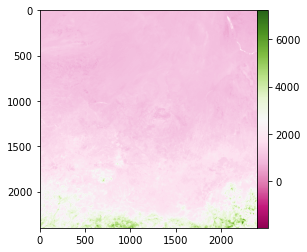

In [34]:
u = np.unique(VI_data) 
bounds = np.concatenate(([VI_data.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [VI_data.max()])) 
  
# norm = colors.BoundaryNorm(bounds, len(bounds)) 
# color_map1 = ['#FFFAFA', '#FFA07A', '#FF6347', '#800000'] 
# color_map = colors.ListedColormap(color_map1)  
  
    
fig, axes = plt.subplots() 
img = axes.imshow(VI_data, cmap = "PiYG", 
                  ) 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 
  
# color_bar.set_ticks(bounds[:-1]+np.diff(bounds)/2.) 
# color_bar.ax.set_yticklabels(color_map1) 
# color_bar.ax.tick_params(labelsize = 10) 
  
plt.show() 

In [35]:
# first step - make four blank arrays for each category
# made them all have set value of -999 (probs a more elegant way of doing this)

# LF = np.zeros((2400, 2400))       # low frequency (never burned)
# LF[LF == 0] = -999

MLF = np.zeros((2400, 2400))      # moderate low frequency (burned 1-3 times)
MLF[MLF == 0] = -999

MHF = np.zeros((2400, 2400))      # moderate high frequency (burned 3 - 10 times)
MHF[MHF == 0] = -999

HF = np.zeros((2400, 2400))       # high frequency (burned more than 10 times)
HF[HF == 0] = -999

In [137]:
# low frequency - this aint right i dont think

for i in blanks:
    result = np.where(data == 0)
    LF[result] = VI_data[result]
    

TypeError: string indices must be integers

In [106]:
# lets check
np.savetxt("C:\\Users\\samgr\\OneDrive\\Desktop\\LF.csv", LF, delimiter=",")

print(LF.max())
print(LF.min())

7224.0
-1983.0


In [36]:
LF = np.zeros((2400, 2400))

for i in blanks:
    with rio.open(VI_Files[0]) as dataset:
        crs = dataset.read_crs()
    
    file_name = VI_Files[0]
    file = SD(file_name, SDC.READ)  
    
    datasets_dic = file.datasets()
    sds_obj = file.select(0)
    data = sds_obj.get() 
    result = np.where(data == 0)
    
    LF[result] += 1 

<ipython-input-37-8109357a30ea>:12: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size ="5 %")


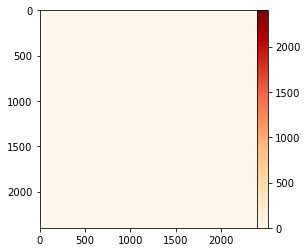

In [37]:
# show low frequency

u = np.unique(LF) 
bounds = np.concatenate(([LF.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [LF.max()])) 
    
fig, axes = plt.subplots() 
img = axes.imshow(LF, cmap = "OrRd")

divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 
  
plt.show() 

In [85]:
# moderate low frequency - rly ugly code

for i in blanks:
    result = np.where(data == 1)
    MLF[result] = blanks[result]
    esult = np.where(data == 2)
    MLF[result] = blanks[result]

<ipython-input-91-7406dd0e2df9>:17: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size ="5 %")


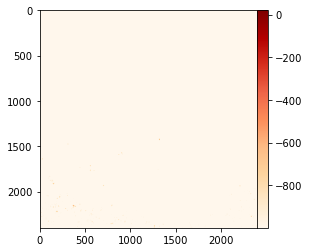

In [91]:
# show moderate low frequency

u = np.unique(MLF) 
bounds = np.concatenate(([MLF.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [MLF.max()])) 
  
# norm = colors.BoundaryNorm(bounds, len(bounds)) 
# color_map1 = ['#FFFAFA', '#FFA07A', '#FF6347', '#800000'] 
# color_map = colors.ListedColormap(color_map1)  
  
    
fig, axes = plt.subplots() 
img = axes.imshow(MLF, cmap = "OrRd", 
                  ) 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 
  
# color_bar.set_ticks(bounds[:-1]+np.diff(bounds)/2.) 
# color_bar.ax.set_yticklabels(color_map1) 
# color_bar.ax.tick_params(labelsize = 10) 
  
plt.show() 

In [87]:
# moderate high frequency - rly rly rly ugly code

for i in blanks:
    result = np.where(data == 4)
    MHF[result] = blanks[result]
    result = np.where(data == 5)
    MHF[result] = blanks[result]
    result = np.where(data == 6)
    MHF[result] = blanks[result]
    result = np.where(data == 7)
    MHF[result] = blanks[result]
    result = np.where(data == 8)
    MHF[result] = blanks[result]
    result = np.where(data == 9)
    MHF[result] = blanks[result]

<ipython-input-92-59c2a528abc0>:17: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size ="5 %")


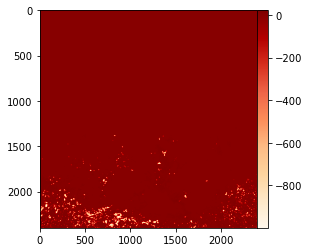

In [92]:
# show moderate high frequency

u = np.unique(MHF) 
bounds = np.concatenate(([MHF.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [MHF.max()])) 
  
# norm = colors.BoundaryNorm(bounds, len(bounds)) 
# color_map1 = ['#FFFAFA', '#FFA07A', '#FF6347', '#800000'] 
# color_map = colors.ListedColormap(color_map1)  
  
    
fig, axes = plt.subplots() 
img = axes.imshow(LF, cmap = "OrRd", 
                  ) 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 
  
# color_bar.set_ticks(bounds[:-1]+np.diff(bounds)/2.) 
# color_bar.ax.set_yticklabels(color_map1) 
# color_bar.ax.tick_params(labelsize = 10) 
  
plt.show() 

In [80]:
# show high frequency
for i in blanks:
    result = np.where(data >= 10)
    HF[result] = blanks[result]

<ipython-input-93-10ca91605cde>:15: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size ="5 %")


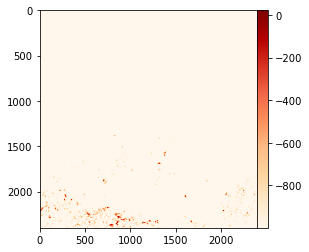

In [93]:
u = np.unique(HF) 
bounds = np.concatenate(([HF.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [HF.max()])) 
  
# norm = colors.BoundaryNorm(bounds, len(bounds)) 
# color_map1 = ['#FFFAFA', '#FFA07A', '#FF6347', '#800000'] 
# color_map = colors.ListedColormap(color_map1)  
  
    
fig, axes = plt.subplots() 
img = axes.imshow(HF, cmap = "OrRd", 
                  ) 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 
  
# color_bar.set_ticks(bounds[:-1]+np.diff(bounds)/2.) 
# color_bar.ax.set_yticklabels(color_map1) 
# color_bar.ax.tick_params(labelsize = 10) 
  
plt.show() 